In [1]:
#调用包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_excel("India.xlsx")
print(data[data.isnull().T.any()])
print("---------------------------------")
data

Empty DataFrame
Columns: [日期, 累计确诊, 治愈人数, 死亡人数]
Index: []
---------------------------------


,日期,累计确诊,治愈人数,死亡人数
0,2020-03-11,57,4,1
1,2020-03-12,68,4,1
2,2020-03-13,76,4,2
3,2020-03-14,96,4,2
4,2020-03-15,98,13,2
...,...,...,...,...
413,2021-04-28,3084849,15086740,204832
414,2021-04-29,3170228,15384418,208330
415,2021-04-30,3268710,15684406,211853
416,2021-05-01,3349644,15992271,215542


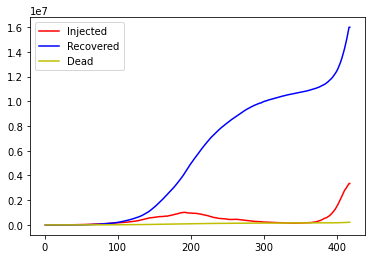

In [3]:
x=list(range(1,data.shape[0]+1))
y1=data['累计确诊'].tolist()
y2=data['治愈人数'].tolist()
y3=data['死亡人数'].tolist()
plt.plot(x,y1,'r',label='Injected')
plt.plot(x,y2,'b',label='Recovered')
plt.plot(x,y3,'y',label='Dead')
plt.legend()
plt.show()

In [4]:
def delta_s(beta,s,i,n,alpha):
    return (-beta*s*i/n-alpha*s)
def delta_e(beta,s,i,n,r1,e):
    return (beta*s*i/n-r1*e)
def delta_i(r1,e,r2d,r2r,i):
    return r1*e-r2d*i-r2r*i
def delta_r(r2r,i,alpha,s):
    return r2r*i+alpha*s
def delta_d(r2d,i):
    return r2d*i
def count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n;alpha=alpha
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(30):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def loss(beta,r1,e0,r2d,r2r,alpha):
    n=1380004000#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    alpha=alpha
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[:31,1].tolist())
    Recovered_true=np.array(data.iloc[:31,2].tolist())
    Dead_true=np.array(data.iloc[:31,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss

In [5]:
import random
import math
import matplotlib.pyplot as plt
#初始化生成chromosome_length大小的population_size个个体的二进制基因型种群
def species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]
def translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_e0=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,50):
            temp_e0+=population[i][j]*(math.pow(2,j-30))
        for j in range(50,65):
            temp_r2d+=population[i][j]*(math.pow(2,j-50))/32768.0
        for j in range(65,80):
            temp_r2r+=population[i][j]*(math.pow(2,j-65))/32768.0
        for j in range(80,95):
            temp_alpha+=population[i][j]*(math.pow(2,j-80))/32768.0
        total=[temp_beta,temp_r1,temp_e0,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def function(temporary):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=loss(temporary[i][0],temporary[i][1],temporary[i][2],temporary[i][3],temporary[i][4],temporary[i][5])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def sum(fitness1):
    total=0
    for i in range(len(fitness1)):
        total+=fitness1[i]
    return total
def newborn(population,born_size,chromosome_length):
    population=population
    #二维列表，包含染色体和基因
    for i in range(born_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

In [6]:
def random_pick(some_list,probabilities,size):
    item_list=[]
    i=0
    while i<size:
        for item,item_probability in zip(some_list,probabilities):
            x=random.uniform(0,1)
            cumulative_probability=item_probability
            if x < cumulative_probability:
                item_list.append(item)
                i=i+1
    return item_list

def selection(population,next_size,fitness1):
    new_fitness=[]
    #单个适应度暂存器
    total_fitness=sum(fitness1)
    #将所有的适应度求和
    for i in range(len(fitness1)):
        new_fitness.append(fitness1[i]/total_fitness)
    select=random_pick(list(range(len(new_fitness))),new_fitness,next_size)
    result=[]
    for i in select:
        result.append(population[i])
    return result

In [7]:
def crossover(population):
#pc是概率阈值，选择单点交叉还是多点交叉，生成新的交叉个体，这里没用
    pop_len=len(population)

    for i in range(pop_len-1):
        cpoint=random.randint(0,len(population[0]))
        #在种群个数内随机生成单点交叉点
        temporary1=[]
        temporary2=[]

        temporary1.extend(population[i][0:cpoint])
        temporary1.extend(population[i+1][cpoint:len(population[i])])
        #将tmporary1作为暂存器，暂时存放第i个染色体中的前0到cpoint个基因，
        #然后再把第i+1个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面

        temporary2.extend(population[i+1][0:cpoint])
        temporary2.extend(population[i][cpoint:len(population[i])])
        # 将tmporary2作为暂存器，暂时存放第i+1个染色体中的前0到cpoint个基因，
        # 然后再把第i个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面
        population[i]=temporary1
        population[i+1]=temporary2
    return population
def mutation(population,pm):
    # pm是概率阈值
    px=len(population)
    # 求出种群中所有个体的个数
    py=len(population[0])
    # 染色体/个体中基因的个数
    for i in range(px):
        if(random.random()<pm):
        #如果小于阈值就变异
            mpoint=random.randint(0,py-1)
            # 生成0到py-1的随机数
            if(population[i][mpoint]==1):
            #将mpoint个基因进行单点随机变异，变为0或者1
                population[i][mpoint]=0
            else:
                population[i][mpoint]=1
    return population

In [8]:
def best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def next_best(population,fitness1,temp_individual,temp_fitness):

    px=len(population)
    bestindividual=temp_individual
    bestfitness=temp_fitness

    for i in range(0,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]

In [9]:
population_size=500
chromosome_length=95
population=species_origin(population_size,chromosome_length)
results=[]
pm=0.5
for m in range(300):
    temporary=translation(population)
    fitness1=function(temporary)
    if m==0:
        best_individual,best_fitness=best(population,fitness1)
    else:
        best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
    print(10000000/best_fitness)
    results.append([best_fitness,best_individual])
     #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
    population=selection(population,450,fitness1)#选择
    population=crossover(population)#交配
    population=mutation(population,pm)#变异
    population=newborn(population,50,95)

2.4129908335480696e+16
82306937672763.36
13592263963435.84
480228095254.467
585572766.2627558
455458803.95701325
185887039.93636766
185887025.342482
185780266.704067
185402333.439444
185355781.21865013
185355781.21865013
185255608.2643719
185255608.2643719
185167897.38620916
185074586.5722926
185074586.5722926
184765148.55973938
184765148.55973938
184765148.55973938
184765148.55973938
184622775.34315106
184572998.58222955
184572998.58222955
179333645.81776103
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
179320381.5188248
172765283.72450846
137734946.71937758
137734946.71937758
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8058913
124752345.8

In [10]:
best=[]
best.append(best_individual)
print(best_individual)
print(translation(best))
print(10000000/best_fitness)

[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.407745361328125, 0.27752685546875, 21.0, 0.00128173828125, 0.063873291015625, 0.0]]
11599430.767518684


In [11]:
first=translation(best)

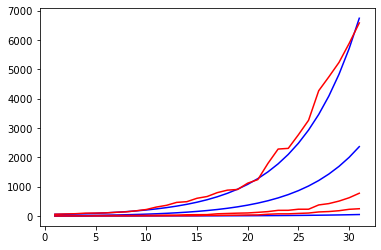

In [12]:
def yuce(beta,r1,e0,r2d,r2r,alpha):
    n=1380004000#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
predict=yuce(first[0][0],first[0][1],first[0][2],first[0][3],first[0][4],first[0][5])
Inject_predict=np.array(predict['累计确诊'].tolist())
Recovered_predict=np.array(predict['治愈人数'].tolist())
Dead_predict=np.array(predict['死亡人数'].tolist())
Inject_true=np.array(data.iloc[:31,1].tolist())
Recovered_true=np.array(data.iloc[:31,2].tolist())
Dead_true=np.array(data.iloc[:31,3].tolist())
x=list(range(1,len(Inject_predict)+1))
plt.plot(x,Inject_predict,'b')
plt.plot(x,Inject_true,'r')
plt.plot(x,Recovered_predict,'b')
plt.plot(x,Recovered_true,'r')
plt.plot(x,Dead_predict,'b')
plt.plot(x,Dead_true,'r')
plt.show()

In [13]:
predict

,S,E,累计确诊,治愈人数,死亡人数
0,1.380004e+09,21.000000,57.000000,4.000000,1.000000
1,1.380004e+09,38.413420,59.114227,7.640778,1.073059
2,1.380004e+09,51.856215,65.923394,11.416598,1.148828
3,1.380004e+09,64.344678,76.019645,15.627342,1.233325
4,1.380004e+09,77.483956,88.923959,20.482967,1.330762
5,1.380004e+09,92.238404,104.633995,26.162833,1.444739
6,1.380004e+09,109.303789,123.415198,32.846150,1.578853
7,1.380004e+09,129.291017,145.708814,40.729085,1.737039
8,1.380004e+09,152.821367,172.096881,50.035987,1.923799
9,1.380004e+09,180.581019,203.295937,61.028381,2.144382


In [14]:
def month_species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

def month_translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,45):
            temp_r2d+=population[i][j]*(math.pow(2,j-30))/32768.0
        for j in range(45,60):
            temp_r2r+=population[i][j]*(math.pow(2,j-45))/32768.0
        for j in range(60,75):
            temp_alpha+=population[i][j]*(math.pow(2,j-60))/32768.0
        total=[temp_beta,temp_r1,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def month_loss(beta,r1,e0,r2d,r2r,month,alpha):
    n=1380004000#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss
def month_function(temporary,e0,month):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=month_loss(temporary[i][0],temporary[i][1],e0,temporary[i][2],temporary[i][3],month,temporary[i][4])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def month_best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def month_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=1380004000#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
def month_yichuan(e0,month):
    population_size=500
    chromosome_length=75
    population=month_species_origin(population_size,chromosome_length)
    results=[]
    pm=0.5
    for m in range(300):
        temporary=month_translation(population)
        fitness1=month_function(temporary,e0,month)
        if m==0:
            best_individual,best_fitness=month_best(population,fitness1)
        else:
            best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
        print(10000000/best_fitness)
        results.append([best_fitness,best_individual])
         #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
        population=selection(population,450,fitness1)#选择
        population=crossover(population)#交配
        population=mutation(population,pm)#变异
        population=newborn(population,50,75)
    mybest=[]
    mybest.append(best_individual)
    print(best_individual)
    print(month_translation(mybest))
    first=month_translation(mybest)
    predict=month_yuce(first[0][0],first[0][1],e0,first[0][2],first[0][3],month,first[0][4])
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    x=list(range(1,len(Inject_predict)+1))
    plt.figure(1)
    plt.plot(x,Inject_predict,'b')
    plt.plot(x,Inject_true,'r')
    plt.figure(2)
    plt.plot(x,Recovered_predict,'b')
    plt.plot(x,Recovered_true,'r')
    plt.figure(3)
    plt.plot(x,Dead_predict,'b')
    plt.plot(x,Dead_true,'r')
    plt.show()
    return predict

5986.405911940527
2.025639395388915e+16
7298669636365519.0
18801715195028.938
60128467560.328156
18264258332.305473
17907371150.34602
17863268536.07066
17863268536.07066
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16313609920.796955
16227048871.502413
16227048871.502413
16227048871.502413
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15219829326.618118
15160927197.163956
15047812900.950842
15047812900.950842
15047812900.950842
13432784201.108973
13016119873.97778
9968073324.211395
4282774822.1112227
1943448411.1236777
1943448411.1236777
891868639.9186338
880033218.3525476
799878440.4159082
723168296.0394179
723168296.0394179
397695229.3116621
39

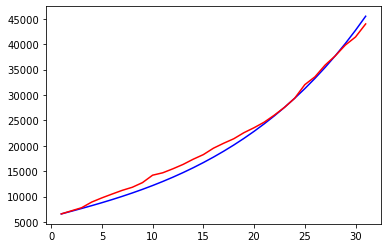

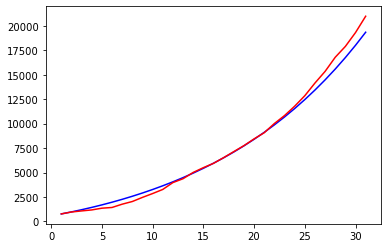

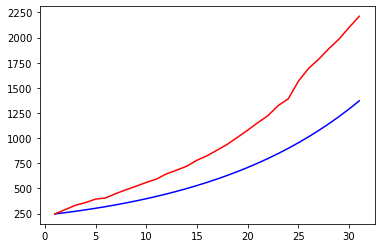

In [15]:
e0=predict.iloc[30,1]
print(e0)
i=0
predict.to_csv('third_predict'+str(i)+'.csv',index=False)
predict=month_yichuan(e0,1)
i=1
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

9.68310464893071e+16
1074156814430169.2
577141486926.915
295365382334.5805
295162241313.0956
295162241313.0956
259564982430.13388
259564982430.13388
259564982430.13388
246758105487.19443
223155082691.3047
223155082691.3047
221158136128.97018
216941565567.67053
216941565567.67053
198798617145.24792
198798617145.24792
198798617145.24792
198798617145.24792
198798617145.24792
198798617145.24792
172000505645.4845
115081839801.26227
115081839801.26227
102874390252.52545
102874390252.52545
102874390252.52545
99345736486.22644
99264654968.9113
65749210277.47181
65749210277.47181
65749210277.47181
61349690602.09279
61349690602.09279
61349690602.09279
60860733240.28078
60860733240.28078
27033245824.261875
6062844915.8101425
6031456249.892695
5612067792.933807
3928728373.5913725
3482623261.138115
3482623261.138115
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.2174754
2073640897.217

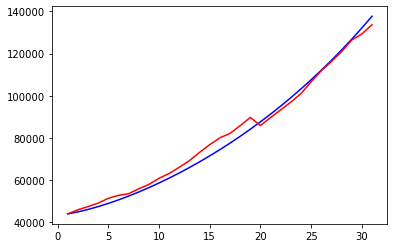

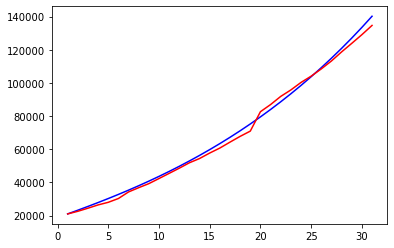

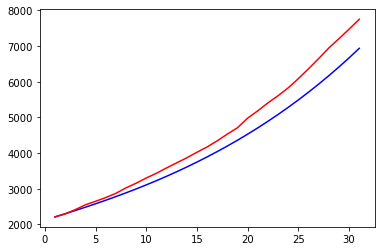

In [16]:
i=2
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.64583216444971e+16
1076181816109029.1
7416762495530.291
1331249084565.2864
1327836423800.028
1327550726411.9568
1320364056709.5413
1320364056709.5413
613104495808.421
613104495808.421
268266284174.34616
268266284174.34616
116617113668.97426
8195775841.169504
4633247321.032331
3626666202.615526
3447191083.5142126
3128839410.8089266
3128839410.8089266
3128839410.8089266
2749911426.992962
2749911426.992962
2749911426.992962
2749911426.992962
2749911426.992962
2749911426.992962
2749911426.992962
2684195474.7567267
2659523907.6168613
2659523907.6168613
2659523907.6168613
2659523907.6168613
2659523907.6168613
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301656.8056326
2571301

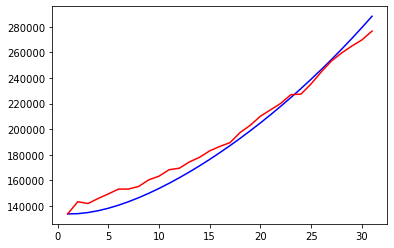

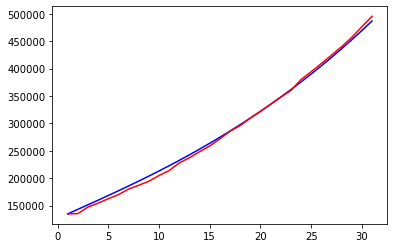

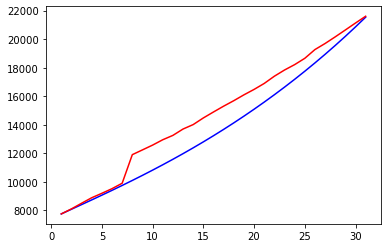

In [17]:
i=3
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

6099192573388266.0
53521129943074.516
12964923798815.771
12516571212881.537
12396936221371.387
11924076123240.787
11683398273039.629
11619989636962.908
11321140079263.736
10502691349719.113
10146632257470.227
10146632257470.227
9476974376060.293
9207745028944.027
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6413685656525.247
6380014609883.634
6160827031886.1045
6160827031886.1045
6160827031886.1045
6160827031886.1045
3913534750028.9834
3913534750028.9834
3913534750028.9834
3913534750028.9834
3913534750028.9834
3913534750028.9834
2521482012432.7964
2057760144717.8325
2057395983520.1453
2057395983520.1453
2036135441346.398
1245530766728.5486
1242440261221.961
1242440261221.961
1242440261221.961
1

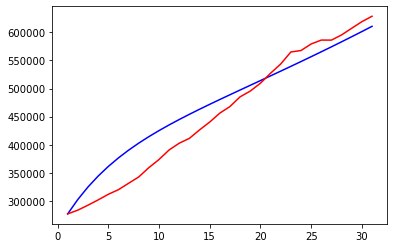

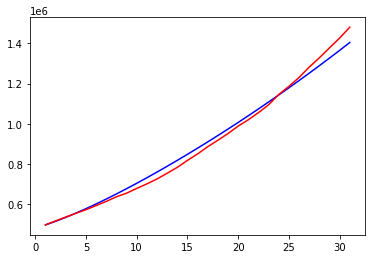

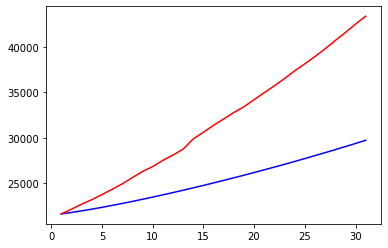

In [18]:
i=4
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.3647506670046912e+16
84899651441258.77
34981253745153.258
23840336902743.043
22458985281285.11
22037885768644.656
21289936193789.027
19582833542208.246
17683287297915.895
17655585062319.754
17655068405967.586
17567681225254.709
16963050067076.03
16963050067076.03
16963050067076.03
16963050067076.03
15789755142737.031
15789755142737.031
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
13097514428838.072
11705989769986.832
11562828610914.332
11562828610914.332
11562828610914.332
11522172414485.215
11522172414485.215
11437608858518.223
10988332302130.36
10988332302130.36
10988332302130.36
9642028768275.219
9642028768275.219
7845607093847.973
6662335403250.378
6626799162519.85
6626799162519.85
6626799162519.85
6607925861021.823
1623282554089.3342
1434282041731.588
875720072581.2168
842035704873.0747
637817943754.756
616760597943.7007
615727045707.5837
558511589336.977

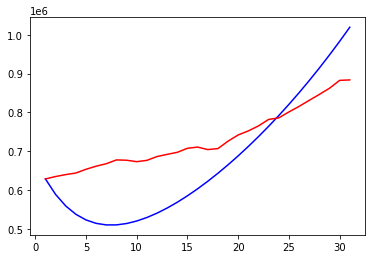

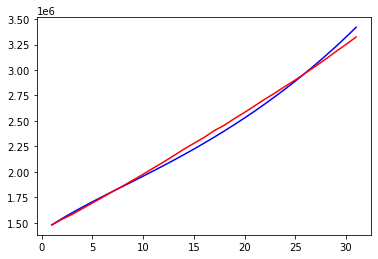

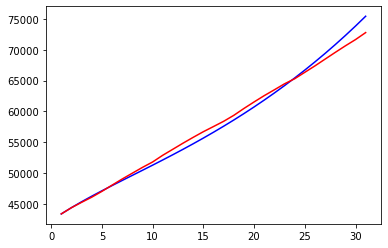

In [19]:
i=5
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

7.351605565482264e+16
458208479653237.8
201609624666885.75
93333673253092.03
68578452806099.33
68578452806099.33
64964002310177.99
57621687749987.234
37239674924979.14
30555648221478.05
30555648221478.05
30555648221478.05
30555648221478.05
30555648221478.05
29724805948309.6
29724805948309.6
29724805948309.6
29724805948309.6
29724805948309.6
29047816717097.67
29047816717097.67
29047816717097.67
29047816717097.67
29047816717097.67
10610405904216.393
10597125512867.83
10312995444634.652
8948262617264.002
8460677041589.014
3074202274533.302
2770488389698.5713
2463160394320.878
2388200106214.989
2244459599257.575
2201852958925.3154
1965338421007.6003
906762257259.6191
906762257259.6191
906762257259.6191
906762257259.6191
749511314956.278
330054419038.57294
330054419038.57294
287460157827.02496
265771198206.11057
191986957672.70654
146993038528.1476
127116690634.87769
91317849676.67795
83510127612.29205
83510127612.29205
83510127612.29205
79415163261.04202
79415163261.04202
79415163261.04202

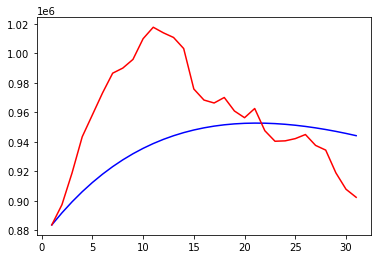

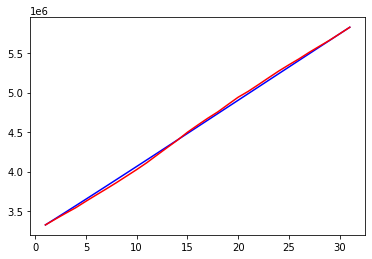

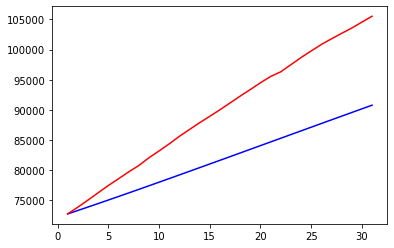

In [20]:
i=6
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3378403290092849.5
771682282623139.2
640146998752395.5
634021877692400.5
278728910366602.78
263234606298620.2
27242426010600.67
25719639565853.93
20807069205138.906
20354005058773.37
20261209409170.652
20261209409170.652
19825319857834.832
19825319857834.832
19825319857834.832
19825319857834.832
19134296816102.656
19134296816102.656
19134296816102.656
19134296816102.656
19134296816102.656
19134296816102.656
19134296816102.656
18834365195254.234
18833689205987.883
18833681735810.984
18833681735810.984
17021907291255.541
17021907291255.541
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
17000675087547.984
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023
15548431570030.023


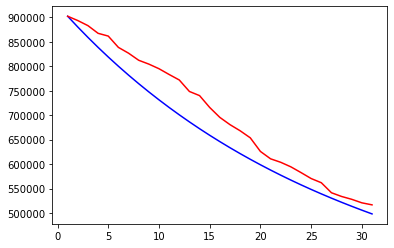

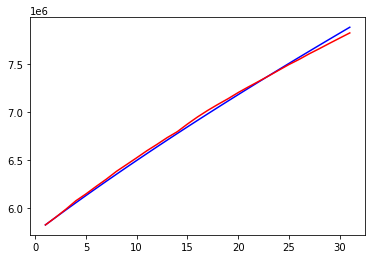

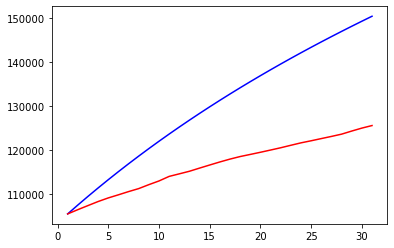

In [21]:
i=7
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

8.244753215896292e+17
3.2586427752348474e+17
5700489012546032.0
114421811966519.88
65593775689480.766
40608646567055.76
25631694132081.094
18725853788524.83
12339447768375.809
9899153747261.965
7361314749689.526
7297700628547.266
7276657838503.615
6856886580911.806
6495245894827.222
6274003280621.552
6274003280621.552
6216213837342.067
6112794143360.0625
6112280463976.035
5830495553774.56
5094359600104.891
5033838886409.465
5033838886409.465
3313757341105.308
3313757341105.308
2518005242763.543
2518005242763.543
2518005242763.543
2518005242763.543
2518005242763.543
2518005242763.543
2518005242763.543
2518005242763.543
1555145014874.8865
1128845582691.6677
940659283143.2512
256499521319.4055
207866180628.9251
207866180628.9251
154600382449.46375
84146700223.39517
76181625463.68433
72755609841.63539
48346750070.54681
48346750070.54681
44261754311.69485
44261754311.69485
36792176181.15391
36507314697.64037
32044203228.30441
32044203228.30441
32044203228.30441
32044203228.30441
32044203228

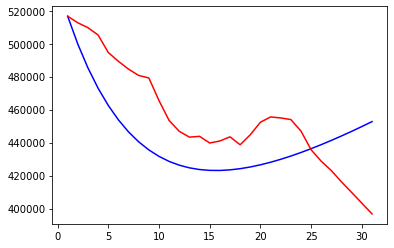

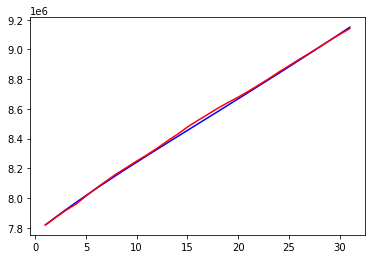

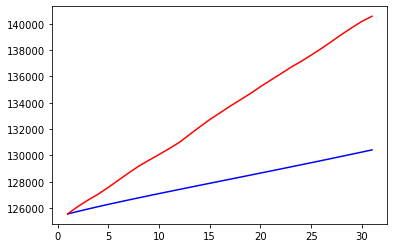

In [22]:
i=8
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.644243536120946e+16
4331114160778055.0
2788796742193351.0
1319847241547117.8
926023357330068.8
420197431513112.0
129484710981245.5
29095368225531.95
11058196067373.324
8091646045217.956
5216603933027.133
5205381285343.363
4913771744268.162
2191765475241.824
2189362907073.6208
2169068364979.2642
462818005468.2216
461852103329.81396
256067956239.41824
188642140944.5815
188642140944.5815
188642140944.5815
187623941561.35025
186164642145.19016
186136589778.44684
179971218072.34415
179971218072.34415
179971218072.34415
179971218072.34415
179361646436.36896
175880363797.1943
175880363797.1943
175880363797.1943
175880363797.1943
175667710522.2912
174452461733.10968
172935754650.1461
172935754650.1461
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
171812052777.7876
1718120

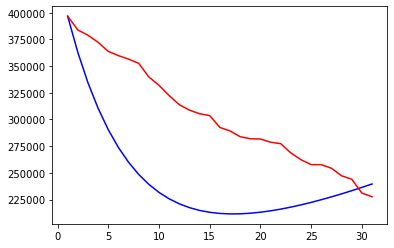

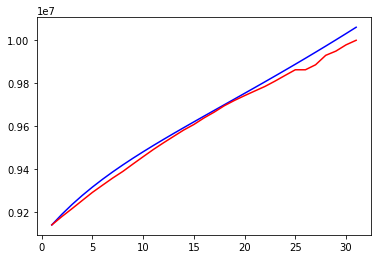

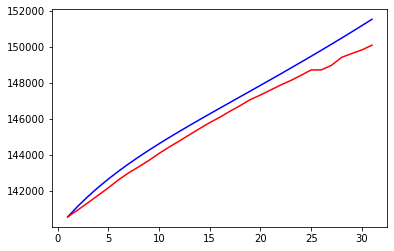

In [23]:
i=9
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.626107349723919e+16
967417439035429.5
155129317601146.44
3251401680213.9165
1953395716728.5078
1831001459683.0615
1643119989501.1333
1621288431525.144
1488324357544.4387
1196052954190.1138
1126334911333.3093
1125956186141.2595
1024240321583.7542
1024240321583.7542
1024240321583.7542
1024240321583.7542
1024240321583.7542
805212109090.6787
771840171842.2828
760247630242.2365
641731660699.986
641731660699.986
473113592624.66504
464339749793.69366
464303859732.61536
461991717362.57556
460928264079.1556
156845340775.28555
147953356030.49466
147953356030.49466
114856795196.30424
107458753153.02786
63982721996.85455
15018456783.495495
8557521087.752799
8358574920.021465
8144567495.510867
7905462897.380122
7882485307.059349
7667705239.425006
7529192494.787142
7291635004.515729
6461299223.880484
6461299223.880484
6461299223.880484
6345788943.4715395
6297856386.839041
5471713574.526796
5358242660.226229
5123392928.8543215
5123392928.8543215
5123392928.8543215
5123392928.8543215
5123392928.8543

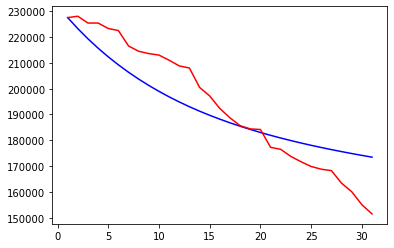

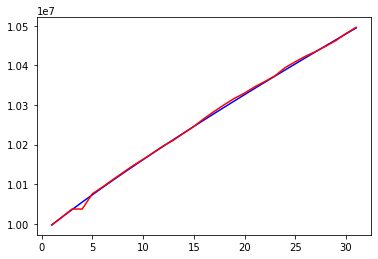

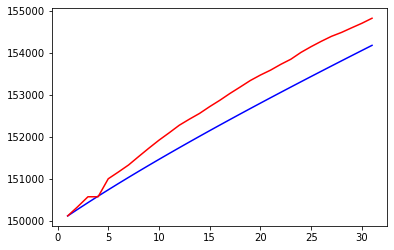

In [24]:
i=10
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.1421832147591811e+17
8188701062028444.0
7888866585420240.0
1090249037807831.9
667247318810042.2
663872431017647.9
407592480395454.0
407592480395454.0
252912698484598.44
248316527412823.44
214941473267513.94
159696438046564.78
87375948902328.62
35069942509008.164
27487757749049.61
2657197305752.294
1613729390205.713
773271298469.8994
754456693890.5453
673618456984.1152
672099934965.8785
663585499586.6584
663585499586.6584
663580545084.6458
663579117601.6735
474791365509.3804
474143170069.4846
474129404023.29425
441157355156.2355
439165384800.84564
428772360192.7147
403059687798.2649
290375877092.4146
166843603964.79236
166634288097.37457
142029770617.7768
107584406227.60928
107584406227.60928
94134406850.518
80791133714.66579
68496960012.2971
46122904971.20326
46122904971.20326
15253027788.938715
6675949210.019256
6675949210.019256
3977088958.130682
2375238020.352556
2322570634.151722
2322570634.151722
1834645525.531678
1755315037.7849176
1624338247.7108946
1624338247.7108946
16243382

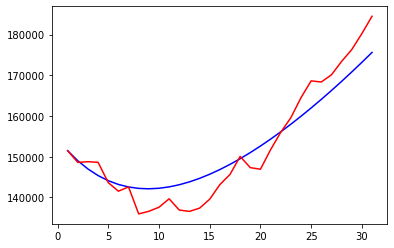

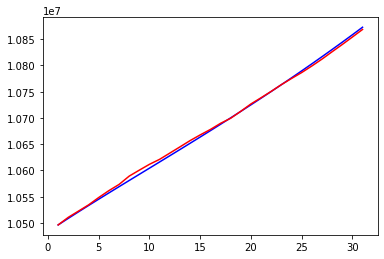

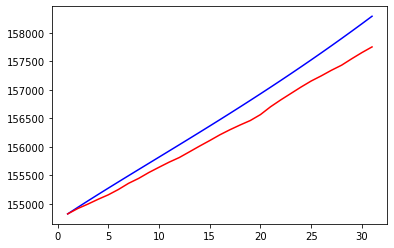

In [25]:
i=11
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

7.72608958735501e+16
1.3849269039151438e+16
4564427540841536.0
2403918703080975.0
1252655220263935.5
377634424352215.7
124022966785141.1
14826811635101.57
10657470898877.482
9040240285411.262
8448310973535.912
8061465977821.246
8003813326825.555
7491134016682.536
7488447694619.598
7488447694619.598
6188402957095.026
6188402957095.026
6033765264588.583
6033765264588.583
6033765264588.583
6033765264588.583
5998625111500.552
5302915057514.492
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4715996535885.444
4673754451076.463
4673754451076.463
4673754451076.463
4027801999999.801
4027801999999.801
4027801999999.801
4027801999999.801
4027801999999.801
2791007513521.836
2791007513521.836
1237939488207.2158
1210525896962.6697
1210525896962.6697
1015945704017.8799
365117598173.1614
331712463031.1039
266776748151.8942
266765487220.31967
260185597051.39496
218046338107.96722
216611672541.93195
21401258

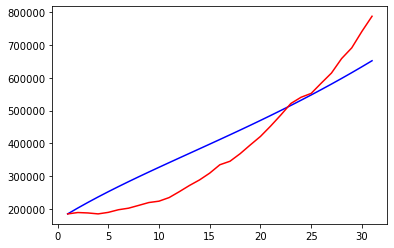

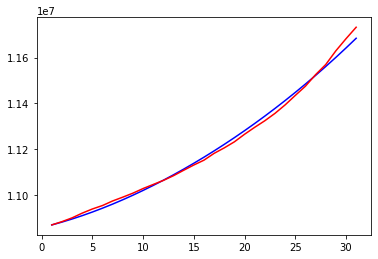

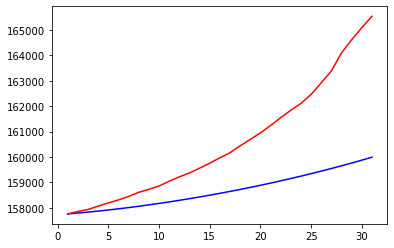

In [26]:
i=12
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

In [27]:
e0=predict.iloc[30,1]
print(e0)
def final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(6000):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def final_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=1380004000#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    print(n*0.00001)
    return predict

20714207.588596113


In [36]:
a=[[9.1552734375e-05, 0.002410888671875, 0.000701904296875, 0.085906982421875, 0.0]]
b=[[0.99920654296875, 0.003021240234375, 0.00018310546875, 0.066802978515625, 0.0]]
c=[[0.99920654296875, 0.003021240234375, 0.00018310546875, 0.066802978515625, 0.0]]
final_result=final_yuce(0.75,0.003,20714207,0.00018, 0.067, 13,0.0091552734375)

13800.04


In [37]:
final_result.to_csv('final_Improve.csv',index=False)